In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from itertools import combinations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load the data from a CSV file
df = pd.read_csv('netflix_titles.csv')

# Display the first few rows of the DataFrame
print(df.head())

  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021        

In [ ]:
def data_inv(df):
    print('netflix movies and shows: ',df.shape[0])
    print('dataset variables: ',df.shape[1])
    print('-'*10)
    print('dateset columns: \n')
    print(df.columns)
    print('-'*10)
    print('data-type of each column: \n')
    print(df.dtypes)
    print('-'*10)
    print('missing rows in each column: \n')
    c=df.isnull().sum()
    print(c[c>0])
data_inv(df)

netflix movies and shows:  8807
dataset variables:  12
----------
dateset columns: 

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')
----------
data-type of each column: 

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object
----------
missing rows in each column: 

director      2634
cast           825
country        831
date_added      10
rating           4
duration         3
dtype: int64


In [ ]:
# Parse 'cast' column: it should be a string of actor names, ideally separated by some character like ','
df['cast'] = df['cast'].apply(lambda x: str(x).split(','))

# Initialize an empty network
G = nx.Graph()

# Loop over rows in the dataframe
for index, row in df.iterrows():
    show_id = row['show_id']
    cast = row['cast']

    # Add an edge between all pairs of actors in each show
    for actor_pair in combinations(cast, 2):
        if G.has_edge(actor_pair[0], actor_pair[1]):
            # If the pair of actors has already been added in the graph, increment the weight of the edge
            G[actor_pair[0]][actor_pair[1]]['weight'] += 1
        else:
            # If the pair is new, add a new edge to the graph
            G.add_edge(actor_pair[0], actor_pair[1], weight=1)

#The graph G is a weighted undirected graph where nodes are actors and there's an edge between two nodes if the actors have appeared
# in the same movie or show. The weight of an edge is the number of shows in which the pair of actors have collaborated.


In [ ]:
#Analyzing graph G:
# to find the actor with the highest degree (most collaborations)
max(dict(G.degree()).items(), key=lambda x: x[1])


(' Anupam Kher', 258)

In [ ]:
plt.figure(figsize=(10,10))
nx.draw(G, with_labels=False, node_size=20)
plt.show()
#(Takes too much time)This will draw a network graph where each node (dot) represents an actor and each edge (line) represents a collaboration between two actors.

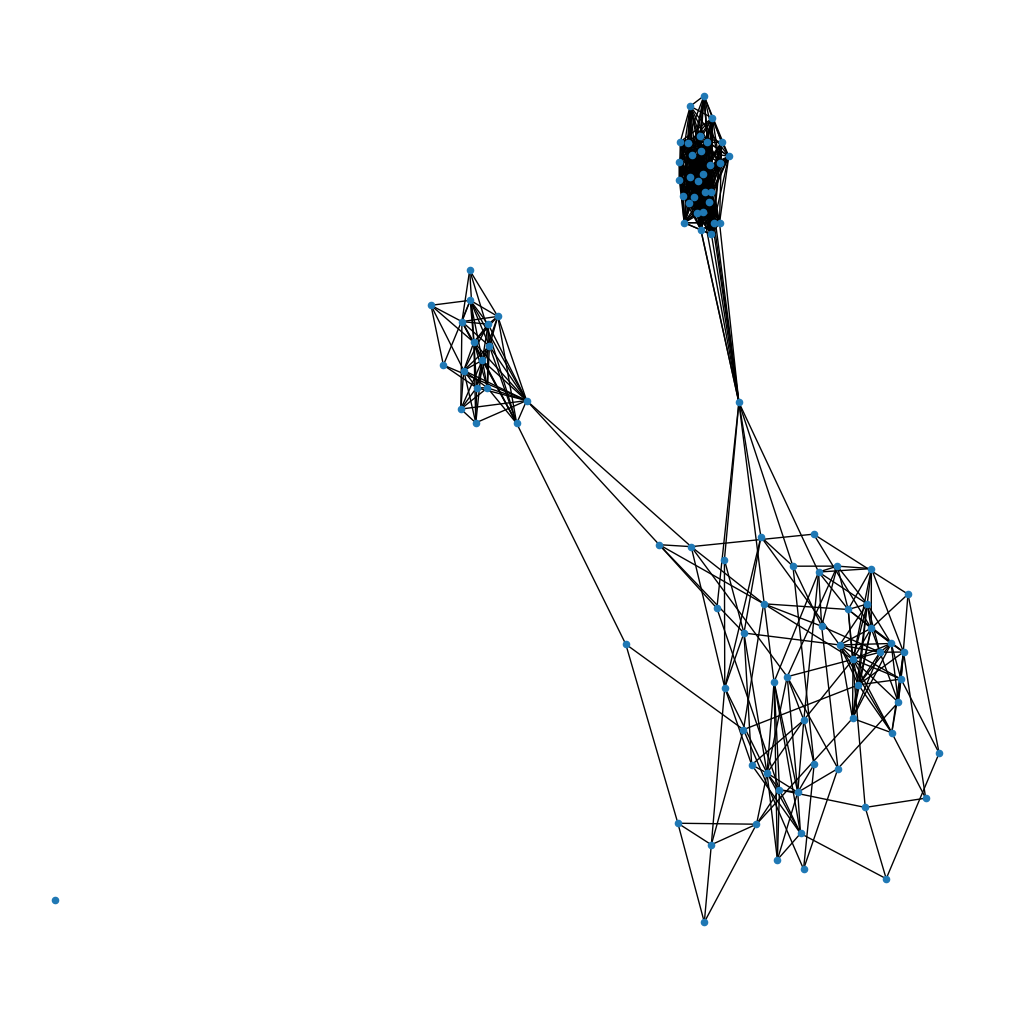

In [ ]:
# Get the 100 nodes with the highest degree
highest_degree_nodes = sorted(dict(G.degree()).items(), key=lambda x: x[1], reverse=True)[:100]
highest_degree_node_names = [node[0] for node in highest_degree_nodes]

# Create subgraph
G_sub = G.subgraph(highest_degree_node_names)

# Plot subgraph
plt.figure(figsize=(10,10))
nx.draw(G_sub, with_labels=False, node_size=20)
plt.show()


In [ ]:
# let's assume cluster is a list of nodes in a cluster
cluster = list(nx.community.greedy_modularity_communities(G_sub))[0]  # change index for different clusters

# inspecting the first cluster
# for actor in cluster:
#     shows = df[df['cast'].apply(lambda x: actor in x)]['country']
#     print(f'Actor {actor} has acted in shows: {list(shows)}')


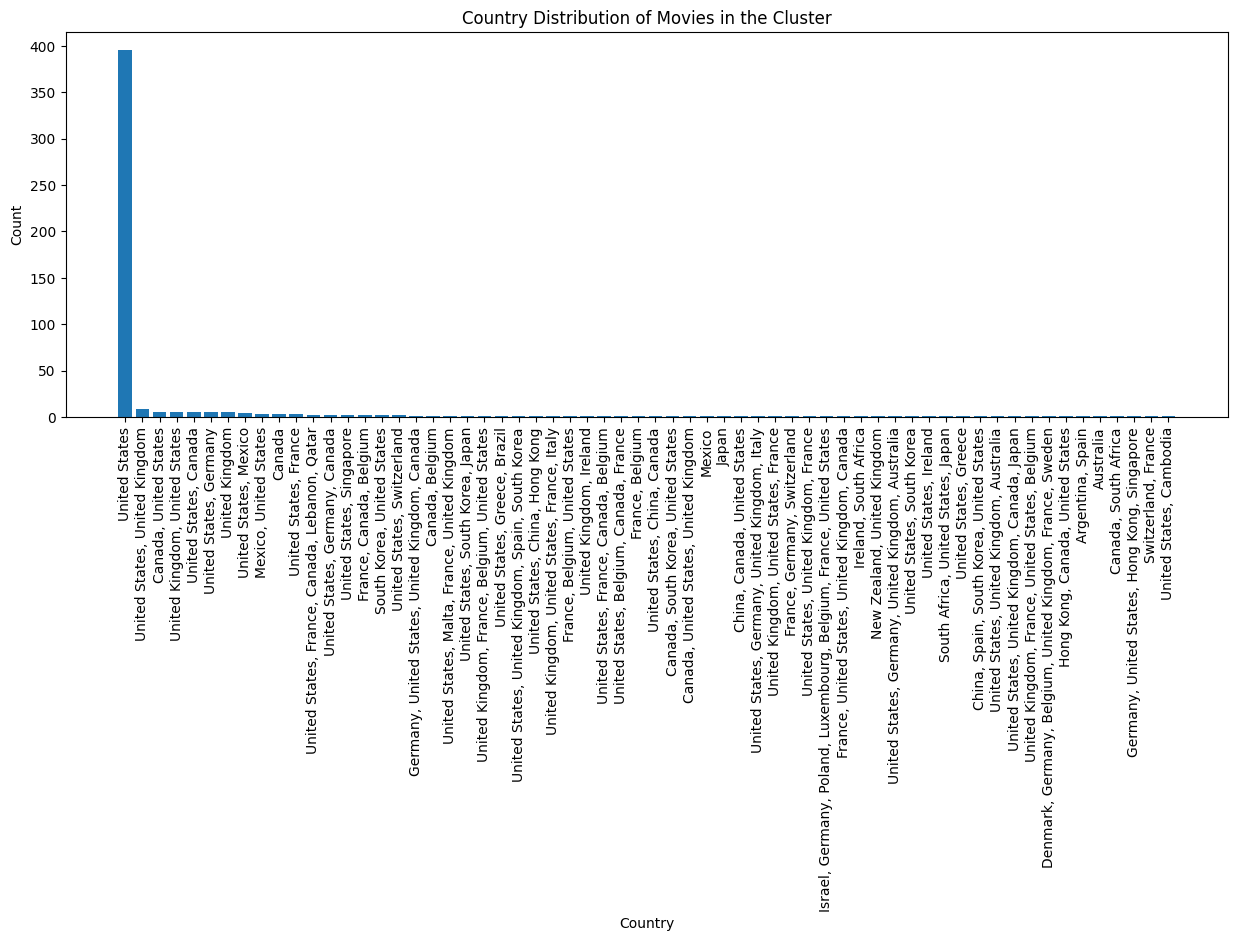

In [ ]:
# removing the NA cells in country and cast columns
df = df.dropna(subset=['country', 'cast'])
# assuming 'cluster' is a list of nodes in a cluster
country_dict = {}
for actor in cluster:
    countries = df[df['cast'].apply(lambda x: actor in x)]['country']
    for country in countries:
        if country in country_dict:
            country_dict[country] += 1
        else:
            country_dict[country] = 1

# sort the countries by frequency
sorted_countries = sorted(country_dict.items(), key=lambda x: x[1], reverse=True)

# split countries and counts into two lists
countries, counts = zip(*sorted_countries)

# create bar chart
plt.figure(figsize=(15,5))
plt.bar(countries, counts)
plt.title('Country Distribution of Movies in the Cluster')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=90) # rotate x-axis labels for better visibility
plt.show()
